В этом ноутбуке рассмотрены несколько моделей:  
* 1-слойная с L_2_reg = 0.  
* 1-слойная с L_2_reg = 1e-2.  
* 1-слойная с L_2_reg = 10.  
* 2-слойная  
* 4-слойная  

Будут проведены несколько экспериментов:  
* Сравнение скорости сходимости в зависимости от :  
> a) типа выборки дистилированной и обычной  
> б) от числа эпох обучения дистилированых данных  
> в) от инициализации модели (рандомная/другая архитектура/ из определенного класса)  

* Сравнение мощности обобщения (для меня это значит что с помощью данной выборки идет обучение затем уже по-другому инициализированных моделей и смотрится качество на них средне и std этого качества)
> а) от числа эпох обучения дистилированых данных  
> б) от наличия регуляризации на дистилляцию (минимизируем отклонение от ближайшего соседа в выборке)  

In [39]:
%load_ext autoreload
%autoreload 2

from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from networks import utils, get_networks
from networks.networks import MyLinearNet
from networks.networks import MyNonLinearNet
import matplotlib.pyplot as plt
import torch
import train_distilled_image
from collections import namedtuple
from basics import evaluate_steps #evaluate_models, format_stepwise_results
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook
from itertools import product
import pickle as pk

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class MyState(dict):
    def __init__(self, *args, **kwargs):
        super(MyState, self).__init__(*args, **kwargs)
        self.__dict__ = self

получение выборки

In [3]:
# data generation
class PlaneData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
def get_plane_dataset(type_ = 'moons', n_samples = 1500, test_size = 0.33, random_state=8):
    if type_ == 'blobs':
        X, y = dataset.smake_blobs(n_samples=n_samples, random_state=random_state)
    elif type_ == 'moons':
        X, y = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=random_state)
    elif type_ == 'circles':
        X, y = dataset.smake_circles(n_samples=n_samples, factor=5, noise=0.05, random_state=random_state)
    else:
        raise ValueError('Unsupported dataset: %s' % type_)
    X = np.array(X, dtype = np.float32)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    train_dataset = PlaneData(X_train, y_train)
    test_dataset = PlaneData(X_test, y_test)
    return train_dataset, test_dataset

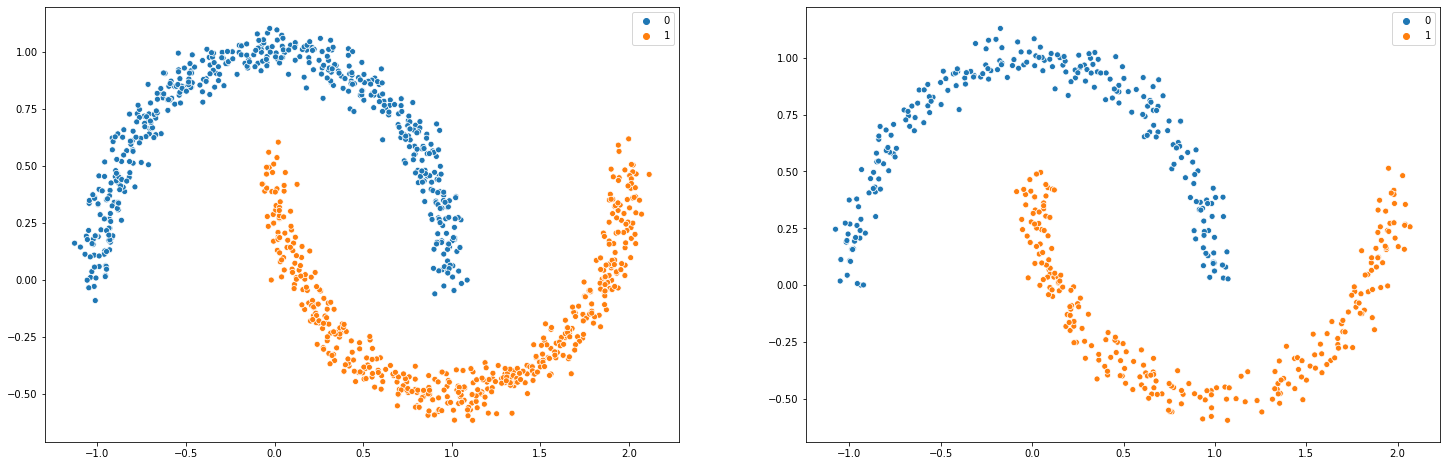

In [4]:
train_dataset, test_dataset = get_plane_dataset('moons')
f, axs = plt.subplots(1, 2, figsize = (25, 8))
for dataset, ax in zip([train_dataset, test_dataset], axs):
    sns.scatterplot(dataset.X[:, 0], dataset.X[:, 1], dataset.y.ravel(), ax = ax)

In [5]:
def visualise_lines(X, y, clf_foo):
    # Plotting decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     dx_min, dx_max = distill_X[:, 0].min() - 1, distill_X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#     dy_min, dy_max = distill_X[:, 1].min() - 1, distill_X[:, 1].max() + 1
#     x_min, x_max = min(x_min, dx_min), max(x_max, dx_max)
#     y_min, y_max = min(y_min, dy_min), max(y_max, dy_max)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    f, [ax1, ax2] = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(18, 8))
    tt = 'My Model'

    Z_data = (torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float())
    Zt = clf_foo(Z_data)

    # logits нужен colormap!
    Z = Zt.detach().numpy().reshape(xx.shape)

    c = ax1.contourf(xx, yy, Z, cmap = 'Blues')
    plt.colorbar(c, ax = ax1)
    msk = y == 1
    ax1.scatter(X[msk, 0], X[msk, 1], c = 'r', s=20, edgecolor='k', label = 'class: 1')
    ax1.scatter(X[~msk, 0], X[~msk, 1], c = 'lightgreen', s=20, edgecolor='k', label = 'class: 0')
    ax1.set_title(tt)

    # classes
    Z = torch.sigmoid(Zt).detach().numpy().round()
    Z = Z.reshape(xx.shape)
    с = ax2.contourf(xx, yy, Z, cmap = 'Blues')
    plt.colorbar(c, ax = ax2)
    msk = y == 1
    ax2.scatter(X[msk, 0], X[msk, 1], c = 'r', s=20, edgecolor='k', label = 'class: 1')
    ax2.scatter(X[~msk, 0], X[~msk, 1], c = 'lightgreen', s=20, edgecolor='k', label = 'class: 0')
    ax2.set_title(tt)
    ax1.set_ylabel('x1')
    ax1.set_xlabel('x2')
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax1.legend()
    ax2.legend()
    # plt.colorbar(ax2)
    return ax1, ax2

# Скорости сходимости

## обычная выборка

In [6]:
from collections import namedtuple

In [7]:
res = {}
torch.manual_seed(42)
np.random.seed(42)
ResEl = namedtuple('ResEl', ['tst_accuracies', 'tr_accuracies', 'losses', 'network'])
for arch_nm in ['MyLinearNet', 'MyNonLinearNet', 'MyMoreNonLinearNet']:
    n_epochs = 150
    tr_loader =  DataLoader(train_dataset, batch_size=64, shuffle = True, pin_memory=True)
    state = MyState( **{
        'local_n_nets': None,
        'num_classes': 2,
        'device': 'cpu',
        'test_nets_type': 'unknown_init',
        'arch': arch_nm,
        'init': 'xavier',
        'init_param': 1,
        'L2_coef': 1e-1
    })
    network = get_networks(state, 1)[0]
    optimizer = optim.Adam(network.parameters(), lr=1e-3, betas=(0.5, 0.999))
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)
    tst_accuracies = []
    tr_accuracies = []
    losses = []

    for epoch in tqdm_notebook(range(n_epochs)):
        network.train()
        for data, target in tr_loader:
            out = network(data)
            data, target = data.to(state.device, non_blocking=True), target.to(state.device, non_blocking=True)
            optimizer.zero_grad()
            output = network(data)
            loss = F.binary_cross_entropy_with_logits(output, target.float().view_as(output))
            losses.append(loss.detach().numpy())
            loss.backward()
            optimizer.step()
        scheduler.step()
        network.eval()
        with torch.no_grad():
            # tst
            tst_data = torch.tensor(test_dataset.X).float()
            ny = torch.sigmoid(network(tst_data)).detach().numpy().round()
            tst_accuracies.append(accuracy_score(test_dataset.y, ny))
            # tr
            tr_data = torch.tensor(train_dataset.X).float()
            ny = torch.sigmoid(network(tr_data)).detach().numpy().round()
            tr_accuracies.append(accuracy_score(train_dataset.y, ny))
    res[arch_nm] = ResEl(tst_accuracies, tr_accuracies, losses, network)
    
    
with open('./April11/usual_data_exp.pk', 'wb') as f:
    pk.dump(res, f)

**визуализация**

In [8]:
with open('./April11/usual_data_exp.pk', 'rb') as f:
    new_res = pk.load(f)

границы решения

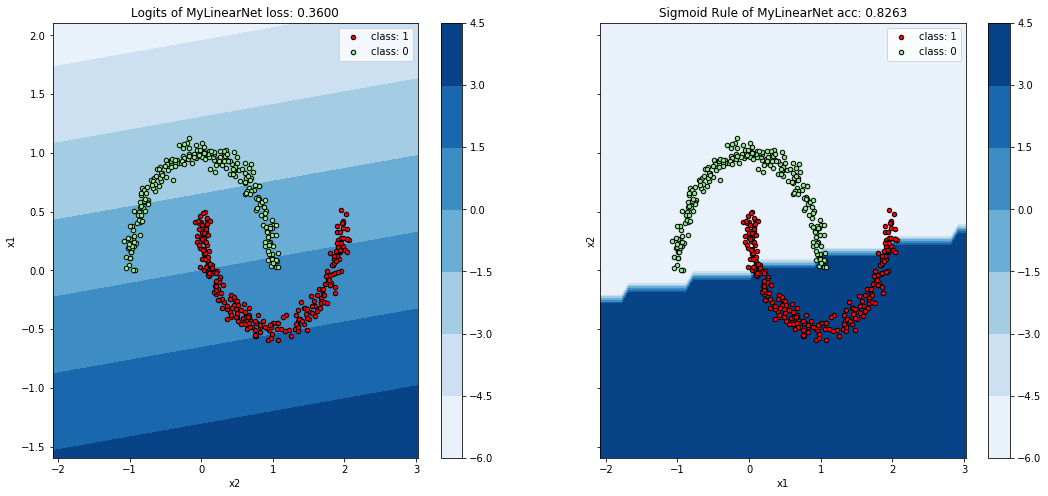

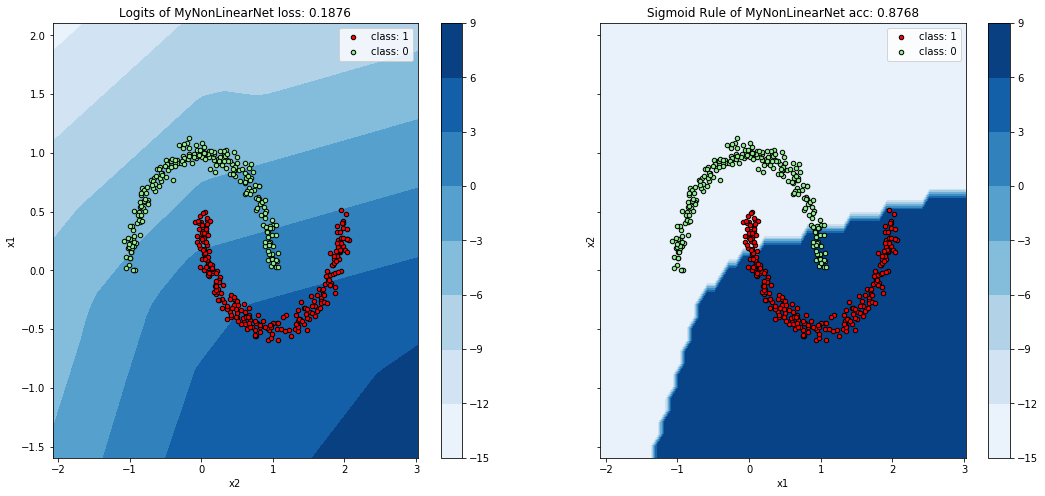

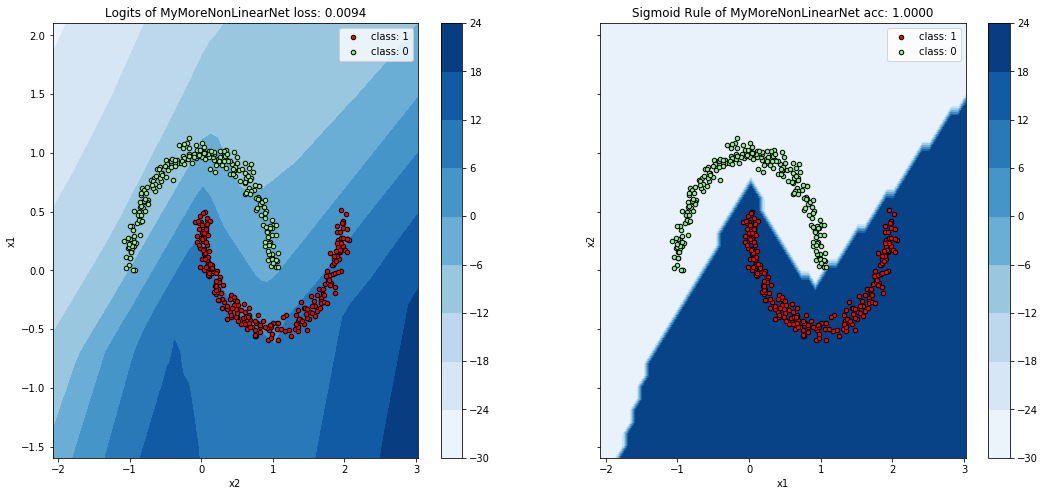

In [9]:
for nm, d in new_res.items():
    ax1, ax2 = visualise_lines(test_dataset.X, test_dataset.y, d.network)
    ax1.set_title(f'Logits of {nm} loss: {d.losses[-1]:.4f}')
    ax2.set_title(f'Sigmoid Rule of {nm} acc: {d.tst_accuracies[-1]:.4f}')

Сходимость

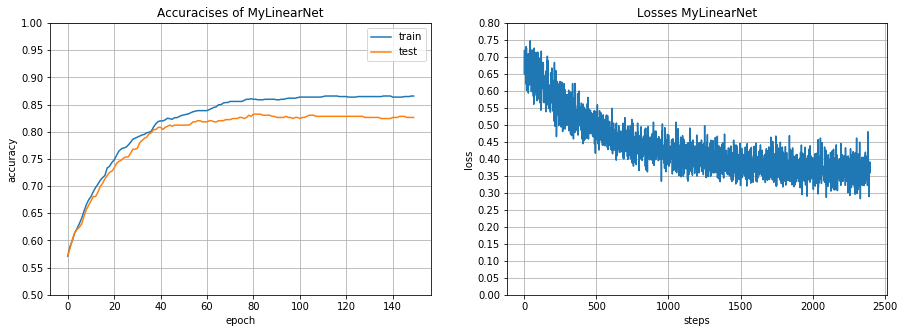

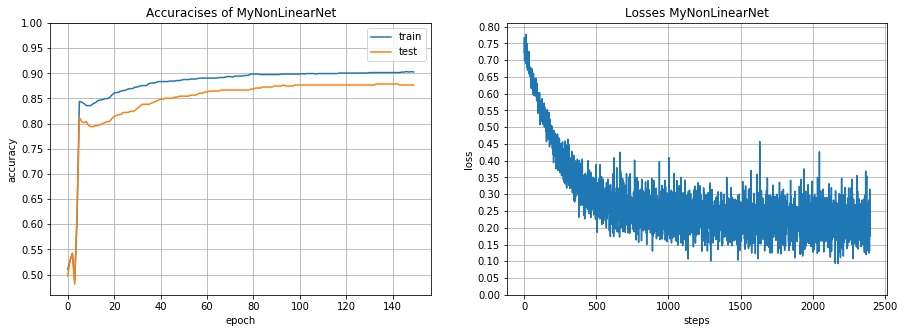

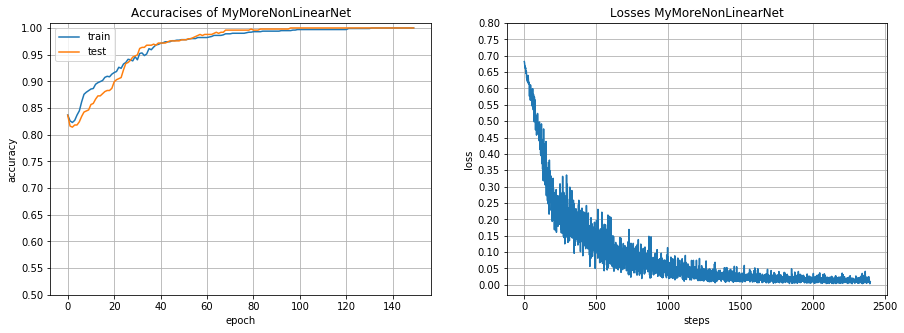

In [43]:
for nm, d in new_res.items():
    f, [ax1, ax2] = plt.subplots(1, 2, figsize = (15, 5))
    # table = pd.DataFrame({'train': d.tr_accuracies, 'test': d.tst_accuracies})
    ax1.plot(range(len(d.tr_accuracies)), d.tr_accuracies, label = 'train')
    ax1.plot(range(len(d.tst_accuracies)), d.tst_accuracies, label = 'test')
    ax1.grid(), ax1.set_xlabel('epoch'), ax1.set_ylabel('accuracy'), ax1.set_yticks(np.linspace(0.5, 1., 11))
    ax1.legend()
    ax2.plot(range(len(d.losses)), d.losses)
    ax2.grid(), ax2.set_xlabel('steps'), ax2.set_ylabel('loss'), ax2.set_yticks(np.linspace(0., 0.8, 17))
    ax2.set_title(f'Losses {nm}')
    ax1.set_title(f'Accuracises of {nm}')

## Сходимость Дистиллированния

In [129]:
res = {}
torch.manual_seed(42)
np.random.seed(42)
ResEl = namedtuple('ResEl', ['state', 'steps', 'losses'])
for arch_nm in tqdm_notebook(['MyLinearNet', 'MyNonLinearNet', 'MyMoreNonLinearNet']):
    state = MyState( **{
        'distill_steps': 1,
        'distill_epochs': 150,
        'num_classes': 2,
        'distilled_images_per_class_per_step': 4,
        'distill_lr': 0.02,
        'lr': 0.01,
        'device': torch.device('cpu'),
        'input_size': dataset.X.shape[1],
        'distributed': False,
        'decay_epochs': 1,
        'decay_factor': 1.,
        'num_workers': 8,
        'batch_size': 64,
        'checkpoint_interval': 100_000,
        'epochs': 75,
        'output_flag': False,
        'test_nets_type': 'unknown_init',
        'arch': arch_nm,
        'init': 'xavier',
        'init_param': 1,
        'mode': 'distill_basic',
        'test_niter': 1,
        'train_nets_type': 'unknown_init',
        'log_interval': 100_000,
        'L2_coef': 1e-1,
    })
    state['train_loader'] = torch.utils.data.DataLoader(train_dataset, batch_size=state['batch_size'],
                            num_workers=state['num_workers'], pin_memory=True, shuffle=True)

    state['test_loader'] = torch.utils.data.DataLoader(test_dataset, batch_size=state['batch_size'],
                            num_workers=state['num_workers'], pin_memory=True, shuffle=False)
    state['models'] = get_networks(state, N = 1)
    state['test_models'] = get_networks(state, N = 1)
    steps, losses = train_distilled_image.distill(state, state.models) # main 131
    res[arch_nm] = ResEl(state, steps, losses)
    
    
with open('./April11/distill_data_exp.pk', 'wb') as f:
    pk.dump(res, f)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Begin of epoch 0 (1 unknown_init nets):   0%|          | 0/2 [00:00<?, ?it/s]

Begin of epoch 0 (1 unknown_init nets): 100%|██████████| 2/2 [00:00<00:00, 17.97it/s]WARNING:root:Skip saving results because output_flag is False


Begin of epoch 0 (1 unknown_init nets):   0%|          | 0/2 [00:00<?, ?it/s]

Begin of epoch 0 (1 unknown_init nets): 100%|██████████| 2/2 [00:00<00:00, 16.36it/s]WARNING:root:Skip saving results because output_flag is F

**визуализация**

In [162]:
with open('./April11/distill_data_exp.pk', 'rb') as f:
    new_res = pk.load(f)

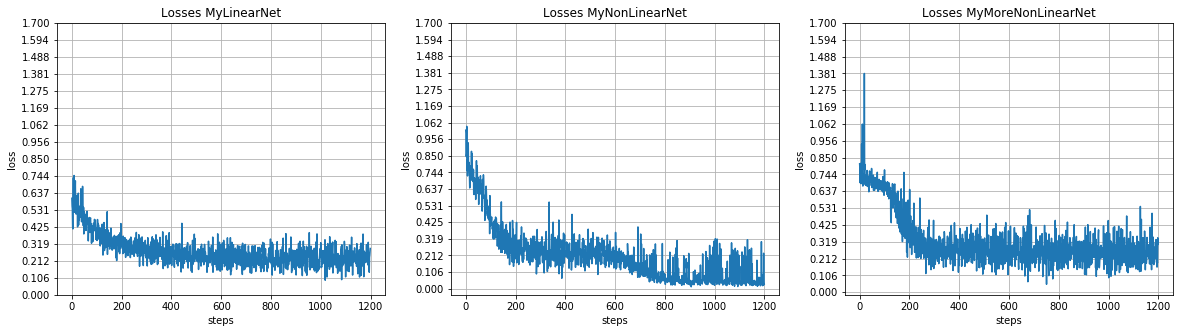

In [163]:
f, axs = plt.subplots(1, 3, figsize = (20, 5))
for (nm, d), ax in zip(new_res.items(), axs):
    # table = pd.DataFrame({'train': d.tr_accuracies, 'test': d.tst_accuracies})
    ax.plot(range(len(d.losses)), d.losses)
    ax.grid(), ax.set_xlabel('steps'), ax.set_ylabel('loss'), ax.set_yticks(np.linspace(0., 1.7, 17))
    ax.set_title(f'Losses {nm}')

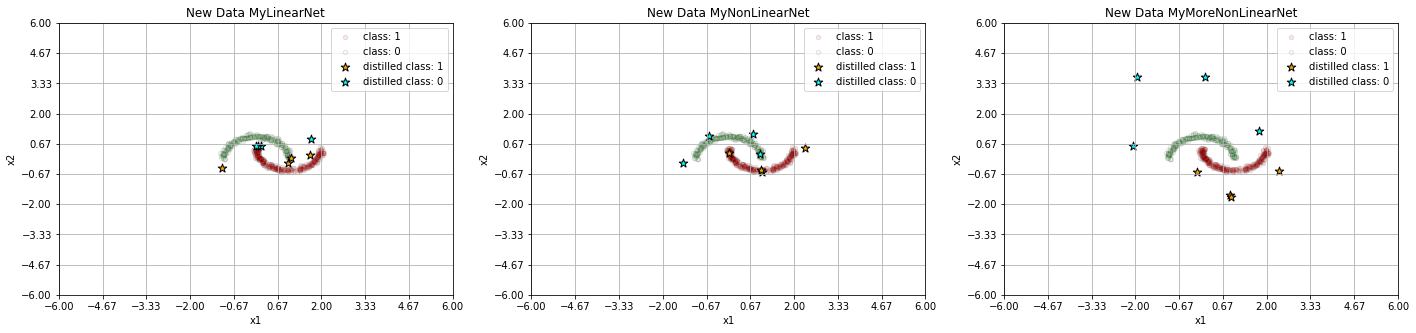

In [182]:
f, axs = plt.subplots(1, 3, figsize = (4*6, 5))
for (nm, d), ax in zip(new_res.items(), axs):
    X, y = test_dataset.X, test_dataset.y
    dX, dy, _ = d.steps[-1]
    dX, dy = dX.detach().numpy(), dy.detach().numpy()
    msk = y == 1
    ax.scatter(X[msk, 0], X[msk, 1], c = 'r', s=20, edgecolor='k', label = 'class: 1', alpha = 0.1)
    ax.scatter(X[~msk, 0], X[~msk, 1], c = 'lightgreen', s=20, edgecolor='k', label = 'class: 0', alpha = 0.1)
    msk = dy == 1
    ax.scatter(dX[msk, 0], dX[msk, 1], c = 'orange', marker = '*',\
               s=80, edgecolor='k', label = 'distilled class: 1')
    ax.scatter(dX[~msk, 0], dX[~msk, 1], c = 'cyan', marker = '*',\
               s=80, edgecolor='k', label = 'distilled class: 0')
    ax.set_yticks(np.linspace(-6, 6, 10))
    ax.set_xticks(np.linspace(-6, 6, 10))
    ax.grid(), ax.set_xlabel('x1'), ax.set_ylabel('x2'), ax.legend()
    ax.set_title(f'New Data {nm}')

## Сходимость на Дистиллированных данных

**добавляем эпох** из раздела **Multiple Epochs**

In [183]:
torch.manual_seed(42)
np.random.seed(42)
results = {}
for nm, d in new_res.items():
    results[nm] = evaluate_steps(d.state, d.steps,\
                             f'distilled with {state.distill_steps} '+\
                             f'steps and {state.distill_epochs} epochs', test_all=True,\
                             test_at_steps=range(len(steps)))



distilled with 1 steps and 150 epochs (1 unknown_init nets):   0%|          | 0/150 [00:00<?, ?it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):   1%|          | 1/150 [00:00<00:19,  7.72it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):   1%|▏         | 2/150 [00:00<00:19,  7.47it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):   3%|▎         | 4/150 [00:00<00:18,  7.80it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):   3%|▎         | 5/150 [00:00<00:20,  7.24it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):   4%|▍         | 6/150 [00:00<00:19,  7.27it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):   5%|▍         | 7/150 [00:00<00:19,  7.34it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):   5%|▌         | 8/150 [00:01<00:19,  7.19it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):   6%|▌         | 9/150 [00:01<00:22,  6.36it/s]

distilled with 1

distilled with 1 steps and 150 epochs (1 unknown_init nets):  47%|████▋     | 71/150 [00:12<00:11,  6.96it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  48%|████▊     | 72/150 [00:12<00:10,  7.33it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  49%|████▊     | 73/150 [00:12<00:10,  7.23it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  49%|████▉     | 74/150 [00:12<00:10,  7.16it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  50%|█████     | 75/150 [00:13<00:10,  7.43it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  51%|█████     | 76/150 [00:13<00:09,  7.44it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  51%|█████▏    | 77/150 [00:13<00:09,  7.94it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  53%|█████▎    | 79/150 [00:13<00:08,  8.56it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  53%|█████▎    | 80/150 [00:13<00:08,  8.16it/s]

d

distilled with 1 steps and 150 epochs (1 unknown_init nets):  95%|█████████▌| 143/150 [00:21<00:00,  8.94it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  96%|█████████▌| 144/150 [00:22<00:00,  7.91it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  97%|█████████▋| 145/150 [00:22<00:00,  7.43it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  97%|█████████▋| 146/150 [00:22<00:00,  7.28it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  98%|█████████▊| 147/150 [00:22<00:00,  7.92it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  99%|█████████▊| 148/150 [00:22<00:00,  7.77it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  99%|█████████▉| 149/150 [00:22<00:00,  7.75it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets): 100%|██████████| 150/150 [00:22<00:00,  7.14it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):   0%|          | 0/150 [00:00<?, ?it/s]

di

distilled with 1 steps and 150 epochs (1 unknown_init nets):  41%|████▏     | 62/150 [00:08<00:12,  7.27it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  42%|████▏     | 63/150 [00:08<00:12,  6.91it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  43%|████▎     | 64/150 [00:08<00:12,  7.08it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  43%|████▎     | 65/150 [00:08<00:12,  7.00it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  44%|████▍     | 66/150 [00:09<00:11,  7.06it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  45%|████▍     | 67/150 [00:09<00:11,  6.97it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  45%|████▌     | 68/150 [00:09<00:11,  7.23it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  46%|████▌     | 69/150 [00:09<00:11,  7.18it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  47%|████▋     | 70/150 [00:09<00:11,  7.09it/s]

d

distilled with 1 steps and 150 epochs (1 unknown_init nets):  88%|████████▊ | 132/150 [00:18<00:02,  7.17it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  89%|████████▊ | 133/150 [00:18<00:02,  7.10it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  89%|████████▉ | 134/150 [00:18<00:02,  7.16it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  90%|█████████ | 135/150 [00:19<00:02,  7.19it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  91%|█████████ | 136/150 [00:19<00:01,  7.12it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  91%|█████████▏| 137/150 [00:19<00:01,  6.92it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  92%|█████████▏| 138/150 [00:19<00:01,  6.99it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  93%|█████████▎| 139/150 [00:19<00:01,  7.36it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  93%|█████████▎| 140/150 [00:19<00:01,  7.1

distilled with 1 steps and 150 epochs (1 unknown_init nets):  34%|███▍      | 51/150 [00:07<00:14,  6.81it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  35%|███▍      | 52/150 [00:07<00:13,  7.39it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  36%|███▌      | 54/150 [00:07<00:12,  7.90it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  37%|███▋      | 55/150 [00:07<00:12,  7.89it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  37%|███▋      | 56/150 [00:07<00:11,  8.03it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  38%|███▊      | 57/150 [00:08<00:11,  7.77it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  39%|███▊      | 58/150 [00:08<00:12,  7.64it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  39%|███▉      | 59/150 [00:08<00:12,  7.26it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  40%|████      | 60/150 [00:08<00:12,  7.00it/s]

d

distilled with 1 steps and 150 epochs (1 unknown_init nets):  81%|████████▏ | 122/150 [00:17<00:03,  7.79it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  82%|████████▏ | 123/150 [00:17<00:03,  8.05it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  83%|████████▎ | 124/150 [00:17<00:03,  7.96it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  83%|████████▎ | 125/150 [00:17<00:03,  8.20it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  84%|████████▍ | 126/150 [00:17<00:02,  8.00it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  85%|████████▍ | 127/150 [00:17<00:03,  7.65it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  85%|████████▌ | 128/150 [00:17<00:03,  7.31it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  86%|████████▌ | 129/150 [00:18<00:02,  7.09it/s]

distilled with 1 steps and 150 epochs (1 unknown_init nets):  87%|████████▋ | 130/150 [00:18<00:02,  7.7

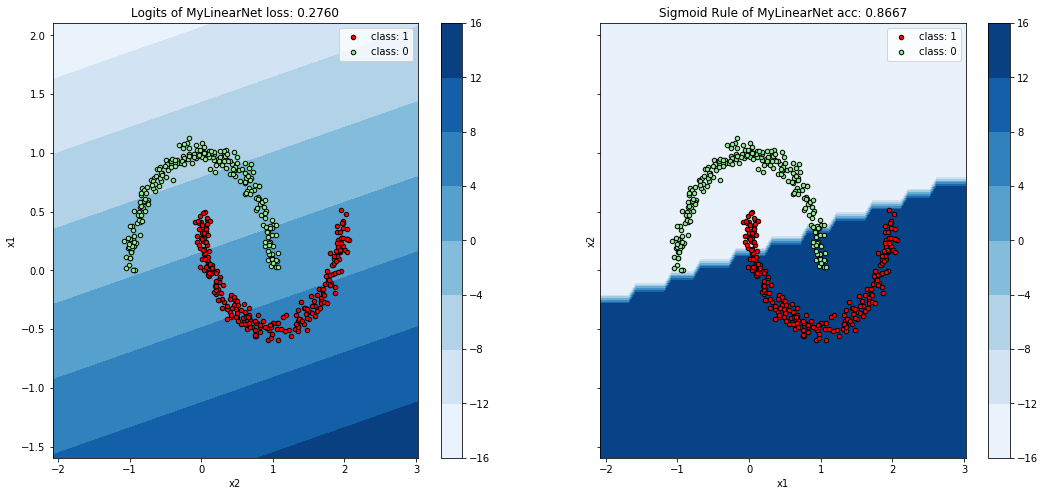

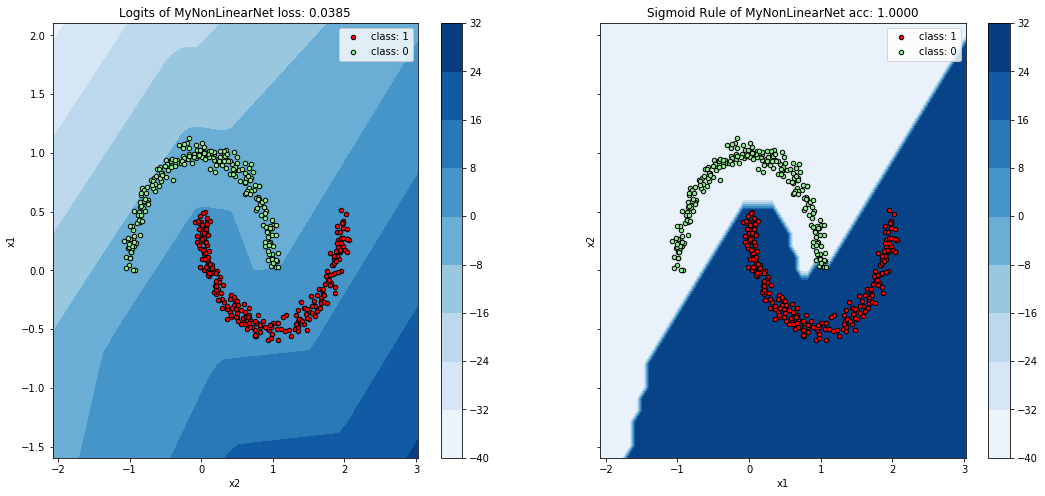

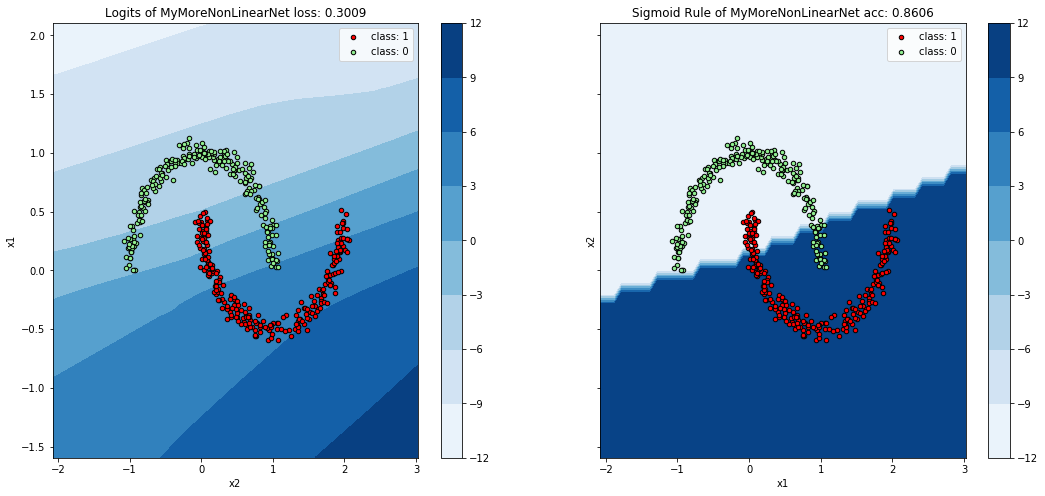

In [189]:
for nm, (test_step_indices, accuracies, losses, model_params) in results.items():
    network = lambda x: new_res[nm].state.test_models[0].forward_with_param(x, model_params[0]) 
    ax1, ax2 = visualise_lines(test_dataset.X, test_dataset.y, network)
    ax1.set_title(f'Logits of {nm} loss: {losses[-1].item():.4f}')
    ax2.set_title(f'Sigmoid Rule of {nm} acc: {accuracies[-1].item():.4f}')

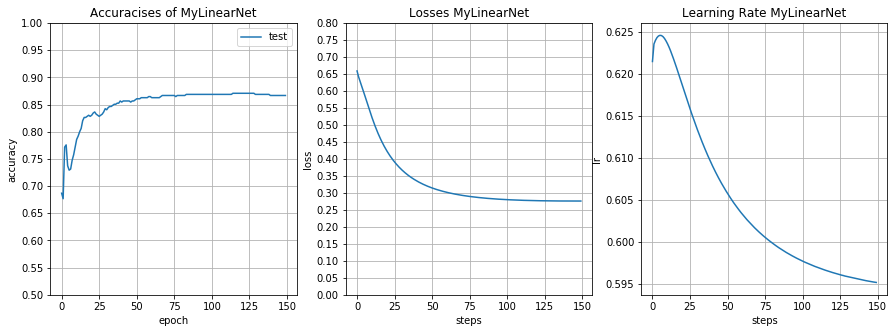

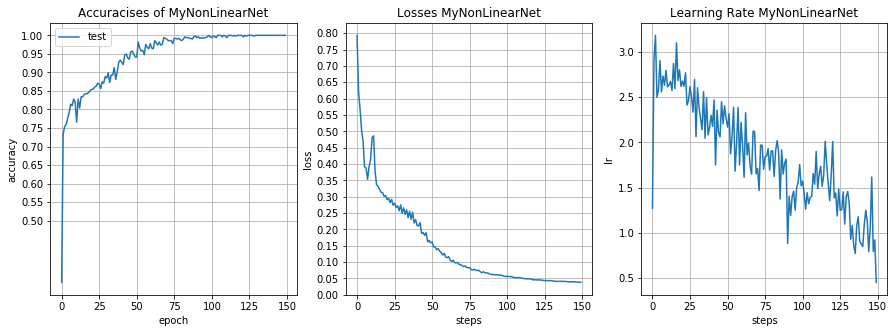

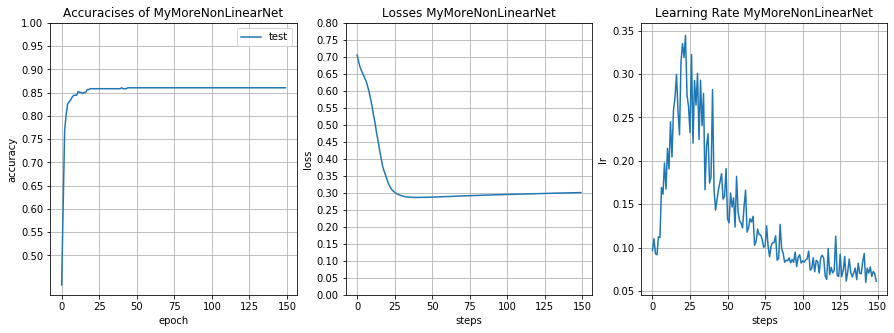

In [190]:
for nm, (test_step_indices, accuracies, losses, model_params) in results.items():
    f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (15, 5))
    # table = pd.DataFrame({'train': d.tr_accuracies, 'test': d.tst_accuracies})
    # ax1.plot(range(len(d.tr_accuracies)), d.tr_accuracies, label = 'train')
    ax1.plot(test_step_indices, accuracies, label = 'test')
    ax1.grid(), ax1.set_xlabel('epoch'), ax1.set_ylabel('accuracy'), ax1.set_yticks(np.linspace(0.5, 1., 11))
    ax1.legend()
    ax2.plot(test_step_indices, losses)
    ax2.grid(), ax2.set_xlabel('steps'), ax2.set_ylabel('loss'), ax2.set_yticks(np.linspace(0., 0.8, 17))
    ax3.plot(test_step_indices, [lr for _, _, lr in new_res[nm].steps])
    ax3.grid(), ax3.set_xlabel('steps'), ax3.set_ylabel('lr')#, ax3.set_yticks(np.linspace(0., 0.8, 17))
    ax1.set_title(f'Accuracises of {nm}')
    ax2.set_title(f'Losses {nm}')
    ax3.set_title(f'Learning Rate {nm}')

# Генерализация дистиллированных выборок